In [1]:
# 'import library'
# ==================================================
import sys, os
import numpy as np
import pandas as pd

def importOwnLib():
    if '/home/miruware/aProjects/lib' not in sys.path:
        sys.path.append('/home/miruware/aProjects/lib')
        print("lib path is successfully appended.")
    else:
        print("lib path is already exists.")

importOwnLib()
import sonyalib as sonya

import importlib
importlib.reload(sonya)

import tensorflow as tf
import keras
from keras.models import Sequential, model_from_json
from keras.layers import Dense, BatchNormalization, Dropout, Activation, Flatten
from keras.backend.tensorflow_backend import set_session
from keras.losses import binary_crossentropy
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit, RepeatedStratifiedKFold, cross_val_score, KFold
from sklearn.metrics import accuracy_score, auc, roc_curve # plot_roc_curve

# -- keras
from keras import losses, callbacks
# -- essential libs
import matplotlib.pyplot as plt
import datetime
from scipy import interp

# ==================================================

config = tf.ConfigProto()
config.gpu_options.visible_device_list = "0"
set_session(tf.Session(config=config))




def cross_validation(model, X, y, nfold = 10, nbatch=10):
    global dir_name
    kfold = KFold(n_splits=nfold, shuffle=True)
    accuracy = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    # K-fold cross validation
    # 학습 데이터를 이용해서 학습

    i = 0
    for train_index, validation_index in kfold.split(X, y):
        # save model and weights per fold

        kX_train, kX_test = X.iloc[train_index], X.iloc[validation_index]
        ky_train, ky_test = y.iloc[train_index], y.iloc[validation_index]

        cbks = [callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.5 ** (epoch // 2)),
                callbacks.TensorBoard(write_graph=False)]
        # hist = model.fit(kX_train, ky_train, epochs=500, batch_size=5, validation_data=(kX_test,ky_test),callbacks=[tb_hist])
        model.fit(kX_train, ky_train, epochs=500, batch_size=nbatch, validation_data=(kX_test, ky_test), callbacks=cbks, verbose=2)

        y_val_cat_prob = model.predict_proba(kX_test)

        k_accuracy = '%.4f' % (model.evaluate(kX_test, ky_test)[1])  # accuracy per fold
        accuracy.append(k_accuracy)

        model_name = target_dir + '/' + str(i) + '_AUC' + str(int(float(k_accuracy)*100))
        model_json = model.to_json()

        with open('{}.json'.format(model_name), 'w') as json_file:
            json_file.write(model_json)  # save model per fold

        model.save_weights('{}.h5'.format(model_name))  # save weight per fold

        # roc curve
        fpr, tpr, t = roc_curve(y.iloc[validation_index], y_val_cat_prob)
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f) ' % (i, roc_auc))
        i = i + 1

        ## -------- Sensitivity -------



        ## ----------------------------


    # 전체 검증 결과 출력
    print('\nK-fold cross validation Accuracy: {}'.format(accuracy))
    # print('\nK-fold cross validation mean Accuracy: {}'.format(np.mean(accuracy)))
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    file_name = str("".format(current_time))

    # plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
    # plt.text(0.32,0.7,'More accurate area',fontsize = 12)
    # plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
    font1 = {'family': 'serif',
             'color': 'darkred',
             'weight': 'normal',
             'size': 10}
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC_PR{}'.format(len(X.columns)))
    plt.legend(loc="lower right")
    # plt.text(0.05, 0.95, 'input: {}\n{}'.format(len(X.columns), X.columns), fontdict=font1)
    # plt.savefig('./optimization/' + datetime.datetime.now().strftime(
    #     "%Y%m%d-%H%M%S") + str(record_count) + '- ROC(input_{}, batch{}, lr_{}, l1_{}, l2_{}).png'.format(len(X.columns), nbatch, nlr, l1, l2))
    # plt.clf()
    plt.savefig('./plot_normalized_meta/ROC_PR{}.png'.format(len(X.columns)))
    plt.show()
    return mean_auc


def create_model(num_input=1, dropout=0, learning_rate=0.005, neurons1=9, neurons2=9):
    global num_features
    num_input = num_features
    keras.backend.clear_session()

    ## 모델 구성하기
    model = Sequential()

    model.add(Dense(neurons1, activation='relu', input_dim=num_input, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dense(neurons2, activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='he_normal'))

    ## 모델 컴파일
    model.compile(optimizer=Adam(learning_rate), loss=binary_crossentropy, metrics=['accuracy'])

    # model.summary()

    return model


# if __name__ == '__main__':

lib path is successfully appended.


Using TensorFlow backend.


Epoch 1/1
176/176 [==============================] - 1s 4ms/step - loss: 0.8889 - acc: 0.4148
Epoch 1/1
176/176 [==============================] - 1s 4ms/step - loss: 0.7410 - acc: 0.5909
Epoch 1/1
176/176 [==============================] - 1s 3ms/step - loss: 0.7591 - acc: 0.3977
Epoch 1/1
176/176 [==============================] - 1s 4ms/step - loss: 1.0226 - acc: 0.4091
Epoch 1/1
176/176 [==============================] - 1s 4ms/step - loss: 0.6806 - acc: 0.5852
Epoch 1/1
176/176 [==============================] - 1s 3ms/step - loss: 0.8697 - acc: 0.6193
Epoch 1/1
177/177 [==============================] - 1s 3ms/step - loss: 1.3927 - acc: 0.4181
Epoch 1/1
177/177 [==============================] - 1s 3ms/step - loss: 1.0054 - acc: 0.4463
Epoch 1/1
177/177 [==============================] - 1s 4ms/step - loss: 0.6735 - acc: 0.5254
Epoch 1/1
177/177 [==============================] - 1s 4ms/step - loss: 0.8487 - acc: 0.3559
Epoch 1/1
176/176 [==============================] - 1s 3ms/

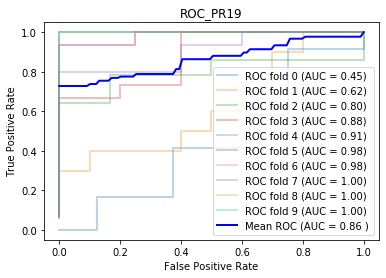

./model_normalized_meta/base_model_RFE_test00_PR19/0_AUC50.h5
./model_normalized_meta/base_model_RFE_test00_PR19/0_AUC50.json
Loaded model from disk ./model_normalized_meta/base_model_RFE_test00_PR19/0_AUC50.h5 .json/h5
./model_normalized_meta/base_model_RFE_test00_PR19/0_AUC50.json ./model_normalized_meta/base_model_RFE_test00_PR19/0_AUC50.h5
0.0025130510330200195
0.3508918285369873
0.0005529522895812988
0.0052988529205322266
0.007668256759643555
0.004323482513427734
0.0004903674125671387
0.0008298158645629883
0.0031700730323791504
0.000980079174041748
0.006830394268035889
0.01212841272354126
0.0017039775848388672
0.005779743194580078
0.010591208934783936
0.002315521240234375
0.002682983875274658
0.0027533769607543945
0.006947755813598633
------------------------
./model_normalized_meta/base_model_RFE_test00_PR19/1_AUC50.h5
./model_normalized_meta/base_model_RFE_test00_PR19/1_AUC50.json
Loaded model from disk ./model_normalized_meta/base_model_RFE_test00_PR19/1_AUC50.h5 .json/h5
./mod

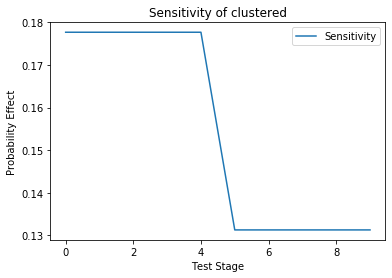

Epoch 1/1
176/176 [==============================] - 1s 4ms/step - loss: 0.6897 - acc: 0.6591
Epoch 1/1
176/176 [==============================] - 1s 4ms/step - loss: 1.2526 - acc: 0.4545
Epoch 1/1
176/176 [==============================] - 1s 4ms/step - loss: 0.7714 - acc: 0.5682
Epoch 1/1
176/176 [==============================] - 1s 4ms/step - loss: 0.6742 - acc: 0.6761
Epoch 1/1
176/176 [==============================] - 1s 4ms/step - loss: 0.6843 - acc: 0.4602
Epoch 1/1
176/176 [==============================] - 1s 4ms/step - loss: 0.9332 - acc: 0.5966
Epoch 1/1
177/177 [==============================] - 1s 3ms/step - loss: 0.8139 - acc: 0.5254
Epoch 1/1
177/177 [==============================] - 1s 3ms/step - loss: 0.9110 - acc: 0.4294
Epoch 1/1
177/177 [==============================] - 1s 4ms/step - loss: 0.7200 - acc: 0.5876
Epoch 1/1
177/177 [==============================] - 1s 4ms/step - loss: 0.7795 - acc: 0.4237
Epoch 1/1
176/176 [==============================] - 1s 4ms/

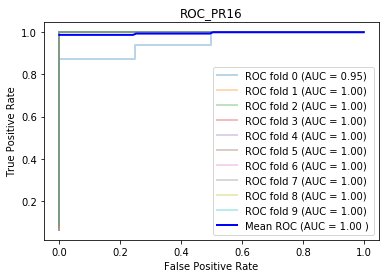

./model_normalized_meta/base_model_RFE_test00_PR16/0_AUC85.h5
./model_normalized_meta/base_model_RFE_test00_PR16/0_AUC85.json
Loaded model from disk ./model_normalized_meta/base_model_RFE_test00_PR16/0_AUC85.h5 .json/h5
./model_normalized_meta/base_model_RFE_test00_PR16/0_AUC85.json ./model_normalized_meta/base_model_RFE_test00_PR16/0_AUC85.h5
0.11793547868728638
0.44656312465667725
0.004586994647979736
0.0016509592533111572
0.01845204085111618
0.012599222362041473
0.023889996111392975
0.017926126718521118
0.027257919311523438
0.3352610170841217
0.05466371774673462
0.05359543859958649
0.08354991674423218
0.05165894329547882
0.030669361352920532
0.25731322169303894
------------------------
./model_normalized_meta/base_model_RFE_test00_PR16/1_AUC100.h5
./model_normalized_meta/base_model_RFE_test00_PR16/1_AUC100.json
Loaded model from disk ./model_normalized_meta/base_model_RFE_test00_PR16/1_AUC100.h5 .json/h5
./model_normalized_meta/base_model_RFE_test00_PR16/1_AUC100.json ./model_normal

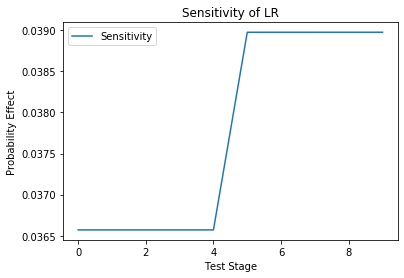

Epoch 1/1
176/176 [==============================] - 1s 4ms/step - loss: 1.0762 - acc: 0.3352
Epoch 1/1
176/176 [==============================] - 1s 4ms/step - loss: 0.7439 - acc: 0.4943
Epoch 1/1
176/176 [==============================] - 1s 4ms/step - loss: 0.6910 - acc: 0.6648
Epoch 1/1
176/176 [==============================] - 1s 4ms/step - loss: 0.9401 - acc: 0.4091
Epoch 1/1
176/176 [==============================] - 1s 3ms/step - loss: 1.0658 - acc: 0.3636
Epoch 1/1
176/176 [==============================] - 1s 3ms/step - loss: 0.7360 - acc: 0.3523
Epoch 1/1
177/177 [==============================] - 1s 4ms/step - loss: 0.6784 - acc: 0.5932
Epoch 1/1
177/177 [==============================] - 1s 4ms/step - loss: 0.6868 - acc: 0.4802
Epoch 1/1
177/177 [==============================] - 1s 3ms/step - loss: 1.0460 - acc: 0.4915
Epoch 1/1
177/177 [==============================] - 1s 3ms/step - loss: 0.6882 - acc: 0.6610
Epoch 1/1
176/176 [==============================] - 1s 4ms/

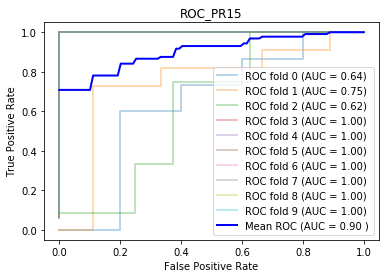

./model_normalized_meta/base_model_RFE_test00_PR15/0_AUC75.h5
./model_normalized_meta/base_model_RFE_test00_PR15/0_AUC75.json
Loaded model from disk ./model_normalized_meta/base_model_RFE_test00_PR15/0_AUC75.h5 .json/h5
./model_normalized_meta/base_model_RFE_test00_PR15/0_AUC75.json ./model_normalized_meta/base_model_RFE_test00_PR15/0_AUC75.h5
0.14329832792282104
0.7894170880317688
0.01197594404220581
0.019305169582366943
0.005536019802093506
0.030848145484924316
0.002692878246307373
0.10728758573532104
0.08894288539886475
0.039008140563964844
0.0056650638580322266
0.03905963897705078
0.08072882890701294
0.03626704216003418
0.024930119514465332
------------------------
./model_normalized_meta/base_model_RFE_test00_PR15/1_AUC60.h5
./model_normalized_meta/base_model_RFE_test00_PR15/1_AUC60.json
Loaded model from disk ./model_normalized_meta/base_model_RFE_test00_PR15/1_AUC60.h5 .json/h5
./model_normalized_meta/base_model_RFE_test00_PR15/1_AUC60.json ./model_normalized_meta/base_model_RFE

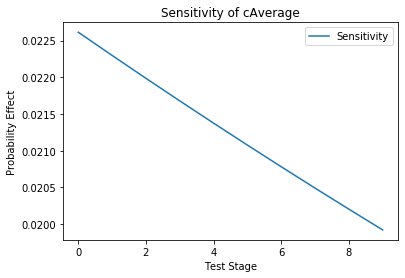

Epoch 1/1
176/176 [==============================] - 1s 4ms/step - loss: 1.3686 - acc: 0.4148
Epoch 1/1
176/176 [==============================] - 1s 4ms/step - loss: 0.6901 - acc: 0.6477
Epoch 1/1
176/176 [==============================] - 1s 3ms/step - loss: 0.7814 - acc: 0.5170
Epoch 1/1
176/176 [==============================] - 1s 4ms/step - loss: 0.7382 - acc: 0.5852
Epoch 1/1
176/176 [==============================] - 1s 4ms/step - loss: 0.7496 - acc: 0.5852
Epoch 1/1
176/176 [==============================] - 1s 3ms/step - loss: 1.0774 - acc: 0.3636
Epoch 1/1
177/177 [==============================] - 1s 4ms/step - loss: 0.8852 - acc: 0.4124
Epoch 1/1
177/177 [==============================] - 1s 4ms/step - loss: 0.8924 - acc: 0.4350
Epoch 1/1
177/177 [==============================] - 1s 3ms/step - loss: 0.9843 - acc: 0.4915
Epoch 1/1
177/177 [==============================] - 1s 3ms/step - loss: 0.7542 - acc: 0.5085
Epoch 1/1
176/176 [==============================] - 1s 4ms/

In [ ]:
# fit random seed for reproductivity
seed = 7
np.random.seed(seed)

# Load metadata

file_path0 = './BRC_input_201116_train.xlsx' # train
file_path1 = './BRC_input_201116_test.xlsx' # test
meta_train = sonya.get_normalized_metadata(file_path0)
meta_test = sonya.get_normalized_metadata(file_path1)
properties = [
    'sex',
    'age',
    'LR',
    'cT',
    'cN',
    'cAverage',
    'cSD',
    'aAverage',
    'aSD',
    'lMax',
    'homogeneous',
    'hetero',
    'rim',
    'clustered',
    'non-mass',
    'AorCa',
    'LymAo',
    'LymCa'
]
num_properties = len(properties)

properties = list(input_X.columns.values)

for nf in range(num_properties - 1):
    
    input_X = meta_train[properties]
    input_y = meta_train['label']

    test_X = meta_test[properties]
    test_y = meta_test['label']

    
    num_features = len(properties) - 0 #nf
    model = KerasClassifier(build_fn=create_model)
    batch = [10, 20, 30, 40]
    epochs = [10, 50, 100]
    lr = [0.001, 0.005, 0.01, 0.05]
    neurons1 = [3, 5, 7, 9, 11]
    neurons2 = [3, 5, 7, 9, 11]

    # batch = [10, 20]
    # epochs = [10]
    # lr = [0.001, 0.005]
    # neurons1 = [3, 5]
    # neurons2 = [3, 5]

    grid = dict(
        neurons1=neurons1,
        neurons2=neurons2,
        batch_size=batch,
        learning_rate=lr
    )


    grid = GridSearchCV(estimator=model, param_grid=grid, scoring='accuracy', cv=10)
    grid_result = grid.fit(input_X, input_y) # 최적의 hyperparameters를 찾는데 testset을 사용하지 않았다.

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    best_model = grid_result.best_estimator_  # 최적의 파라미터로 모델 생성
    predictions = best_model.predict(test_X) # 최적모델 test 진행
    accuracy = accuracy_score(test_y, predictions)
    print(accuracy) # 최적모델 accuracy 출력

    with open("/home/miruware/aProjects/BRC_metastasis/normalized_meta.txt", "r+") as file:
        input_params = str(list(test_X))
        best_result = "Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)

        file.write(input_params + '\n' + str(best_result) + "\n" + str(accuracy) + "\n")

    # grid_result.best_params_.get('batch_size')

    best_lr = grid_result.best_params_.get('learning_rate')
    best_batch = grid_result.best_params_.get('batch_size')
    best_l1 = grid_result.best_params_.get('neurons1')
    best_l2 = grid_result.best_params_.get('neurons2')

    target_dir = './model_normalized_meta/base_model_RFE_test00_PR' + str(num_features)
    sonya.createFolder(target_dir)
    # seperate dataset to train data & test data
    my_model = create_model(num_input=num_features, learning_rate=best_lr, neurons1=best_l1, neurons2=best_l2)
    roc_result = cross_validation(my_model, input_X, input_y, nfold=10, nbatch=best_batch)


    # -------------------------------- rfe --------------------------------------
    '--------------------- load model --------------------------- '
    # ==================================================================
    target_dir = './model_normalized_meta/base_model_RFE_test00_PR{}'.format(num_features)  # 0-th elimination
    # target_dir = './result_RFE_test01_AUC62'     # 1-th elimination        # rfe_1 Skin Flap vs GI flap_0
    # ==================================================================
    


    raw_data = input_X
    data_columns_size = input_X.columns.size

    raw_data_reshape = raw_data
    data_trans = raw_data_reshape

    x_raw_data = data_trans

    from scipy.stats import zscore

    X_total = x_raw_data

    x_input = X_total
    numvars = x_input.shape[1]

    x_sens_base2 = x_input.median()  # Column별 median
    x_sens_base = x_input.mean()  # Column별 median
    for seq_id in range(numvars):
        if len(x_input.iloc[:, seq_id].unique()) == 2:
            x_sens_base[seq_id] = 0  # Binary var는 0으로

    Sens_test_num = 10
    Pred_rx1 = np.zeros((Sens_test_num, len(x_sens_base)))  # 변수별 Sens_test결과 array
    # Pred_rx1 = pd.DataFrame()
    Pred_diff_stage = []

    min(x_input.iloc[:, 1])
    max(x_input.iloc[:, 1])

    x_input = np.array(x_input)

    # -------------------------------------------------------
    import os

    def list_files_subdir(destpath, ext):
        filelist = []
        for path, subdirs, files in os.walk(destpath):
            for filename in files:
                f = os.path.join(path, filename)
                if os.path.isfile(f):
                    if filename.endswith(ext):
                        filelist.append(f)
        filelist.sort()
        return filelist


    # filelist = list_files_subdir(strdirectory_fc, 'txt')
    h5_list = list_files_subdir(target_dir, 'h5')
    json_list = list_files_subdir(target_dir, 'json')
    # -------------------------------------------------------

    index_list = []
    value_list = []

    df_effect = pd.DataFrame(raw_data.columns)
    for i in range(len(h5_list)):
        index_list = []
        value_list = []
        print(h5_list[i])
        print(json_list[i])
        # load model & weights
        json_name = (json_list[i])
        # json_file = open(fileName+".json", "r")
        json_file = open(json_name, "r")
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        #
        h5_file = h5_list[i]
        loaded_model.load_weights(h5_file)
        print("Loaded model from disk", h5_file, ".json/h5")
        print(json_name, h5_file)
        '--------------------- end of load model --------------------------- '
        #
        #
        # sigma = -1
        sigma = 2
        for seq_id in range(numvars):
            # for seq_id in range(1):
            X_sens_test = np.tile(x_sens_base, (Sens_test_num, 1))  # Make test base
            if (len(np.unique(x_input[:, seq_id])) == 2):
                X_sens_test[(Sens_test_num // 2):, seq_id] = 1
            else:
                if sigma == -1:
                    X_sens_test[:, seq_id] = np.linspace(min(x_input[:, seq_id]),
                                                         max(x_input[:, seq_id]), Sens_test_num)
                elif sigma > 0:
                    x_avg = x_input[:, seq_id].mean();
                    x_sd = x_input[:, seq_id].std()
                    X_sens_test[:, seq_id] = np.linspace(x_avg - (sigma * x_sd), x_avg + (sigma * x_sd), Sens_test_num)
            loaded_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
            y_pred = loaded_model.predict_proba(X_sens_test)
            # Pred_rx1.iloc[:, seq_id] = y_pred     # class를 기준으로 함
            Pred_rx1[:, seq_id] = y_pred[:, 0]  # '0' for sigmoid, '1' for softmax # class를 기준으로 함
            # y_pred_softmax = resto_sess.run(tf.nn.softmax(y_pred))    # Pred_rx0[:, seq_id] = y_pred_softmax[:, 0]
            Pred_diff = np.max(Pred_rx1[:, seq_id], axis=0) - np.min(Pred_rx1[:, seq_id], axis=0)
            Pred_diff_stage.append(Pred_diff)
            print(Pred_diff)
        print("------------------------")
        df_effect[1 + i] = Pred_diff_stage
        Pred_diff_stage = []

    df_effect[1 + numvars] = df_effect.mean(axis=1)
    df_effect[2 + numvars] = df_effect.std(axis=1)
    df_effect = df_effect.rename(columns={1 + numvars: 'mean'})
    df_effect = df_effect.rename(columns={2 + numvars: 'std'})
    df_effect1 = df_effect.sort_values(by=['mean'], axis=0)
    df_effect1['fNum'] = df_effect1.index
    df_effect1 = df_effect1.reset_index(drop=True)
    df_effect0 = df_effect1
    df_effect1 = df_effect1.filter([0, 'fNum', 'mean', 'std'])
    df_effect2 = df_effect1.filter([0, 'fNum', 'mean'])

    df_effect0.to_csv(target_dir + "/rfe" + '.txt')

    elim_idx, elim_pred_diff = min(enumerate(df_effect['mean']), key=lambda x: x[1])

    elim_fName = X_total.columns[elim_idx]
    print("Elim target : ", "#", elim_idx, " ", elim_fName, "w/ effect of ", elim_pred_diff)
    print(df_effect2)

    plt.plot(Pred_rx1[:, elim_idx], label='Sensitivity'.format(elim_pred_diff, elim_fName))
    plt.title('Sensitivity of {}'.format(elim_fName))
    plt.ylabel("Probability Effect")
    plt.xlabel("Test Stage")
    plt.legend(loc="best")
    plt.savefig('./plot_normalized_meta/{}.Sensitivity of {}.png'.format(str(nf) ,elim_fName))
    plt.show()

    properties.remove(elim_fName)

In [22]:
str(list(test_X))

"['sex', 'age', 'LR', 'cT', 'cN', 'cAverage', 'cSD', 'aAverage', 'aSD', 'lMax', 'homogeneous', 'hetero', 'rim', 'clustered', 'non-mass', 'AorCa', 'LymAo', 'LymCa', 'label']"

## =============== model training ===============

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score, KFold
from sklearn.metrics import auc, roc_curve # plot_roc_curve
# -- keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Flatten, BatchNormalization, Dropout
from keras import losses, callbacks
import keras
# -- essential libs
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import interp

import pandas as pd
from keras.models import model_from_json

def mlp_model(num_input=9, dropout=0, lr=0.005, l1=9, l2=9):

    keras.backend.clear_session()
    ## 모델 구성하기
    model = Sequential()

    model.add(Dense(l1, activation='relu', input_dim=num_input, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dense(l2, activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='he_normal'))

    ## 모델 컴파일
    model.compile(optimizer=Adam(lr), loss=losses.binary_crossentropy, metrics=['accuracy'])

    # model.summary()
    return model


def cross_validation(model, X, y, nfold = 10, nbatch=10):
    global dir_name
    kfold = KFold(n_splits=nfold, shuffle=True)
    accuracy = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    # K-fold cross validation
    # 학습 데이터를 이용해서 학습

    i = 0
    for train_index, validation_index in kfold.split(X, y):
        # save model and weights per fold

        kX_train, kX_test = X.iloc[train_index], X.iloc[validation_index]
        ky_train, ky_test = y.iloc[train_index], y.iloc[validation_index]

        cbks = [callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.5 ** (epoch // 2)),
                callbacks.TensorBoard(write_graph=False)]
        # hist = model.fit(kX_train, ky_train, epochs=500, batch_size=5, validation_data=(kX_test,ky_test),callbacks=[tb_hist])
        model.fit(kX_train, ky_train, epochs=500, batch_size=nbatch, validation_data=(kX_test, ky_test), callbacks=cbks, verbose=2)

        y_val_cat_prob = model.predict_proba(kX_test)

        k_accuracy = '%.4f' % (model.evaluate(kX_test, ky_test)[1])  # accuracy per fold
        accuracy.append(k_accuracy)

        model_name = dir_name + '/' + str(i) + '_AUC' + str(int(float(k_accuracy)*100))
        model_json = model.to_json()

        with open('{}.json'.format(model_name), 'w') as json_file:
            json_file.write(model_json)  # save model per fold

        model.save_weights('{}.h5'.format(model_name))  # save weight per fold

        # roc curve
        fpr, tpr, t = roc_curve(y.iloc[validation_index], y_val_cat_prob)
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f) ' % (i, roc_auc))
        i = i + 1

        ## -------- Sensitivity -------



        ## ----------------------------


    # 전체 검증 결과 출력
    print('\nK-fold cross validation Accuracy: {}'.format(accuracy))
    # print('\nK-fold cross validation mean Accuracy: {}'.format(np.mean(accuracy)))
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    file_name = str("".format(current_time))

    # plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
    # plt.text(0.32,0.7,'More accurate area',fontsize = 12)
    # plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
    font1 = {'family': 'serif',
             'color': 'darkred',
             'weight': 'normal',
             'size': 10}
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC_PR{}'.format(len(X.columns)))
    plt.legend(loc="lower right")
    # plt.text(0.05, 0.95, 'input: {}\n{}'.format(len(X.columns), X.columns), fontdict=font1)
    # plt.savefig('./optimization/' + datetime.datetime.now().strftime(
    #     "%Y%m%d-%H%M%S") + str(record_count) + '- ROC(input_{}, batch{}, lr_{}, l1_{}, l2_{}).png'.format(len(X.columns), nbatch, nlr, l1, l2))
    # plt.clf()
    plt.savefig('./plots/ROC_PR{}.png'.format(len(X.columns)))
    plt.show()
    return mean_auc



if __name__ == '__main__':

    # Load metadata

    file_path0 = './BRC_input_201116.xlsx'
    metadata = sonya.get_original_metadata(file_path0)

    # properties = list(metadata.columns.values)
    # properties.remove('label')
    # X = metadata[properties]
    # y = metadata['label']

    X = metadata[[
        # 'sex',
        # 'age',
        # 'LR',
        #'cT',
        # 'cN',
        # 'cAverage',
        # 'cSD',
        # 'aAverage',
        # 'aSD',
        # 'lMax',
        # 'homogeneous',
        # 'hetero',
        # 'rim',
        # 'clustered',
        # 'non-mass',
        # 'AorCa',
        'LymAo',
        # 'LymCa'
    ]]
    y = metadata['label']
    num_input = len(X.columns)

    dir_name = './base_model_RFE_test00_PR' + str(num_input)
    sonya.createFolder(dir_name)
    # seperate dataset to train data & test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    my_model = mlp_model(num_input, lr=0.05, l1=9, l2=5)
    roc_result = cross_validation(my_model, X_train, y_train, nfold=10, nbatch=40)


# -------------------------------- rfe --------------------------------------
    '--------------------- load model --------------------------- '
    # ==================================================================
    target_dir = './base_model_RFE_test00_PR{}'.format(num_input)  # 0-th elimination
    # target_dir = './result_RFE_test01_AUC62'     # 1-th elimination        # rfe_1 Skin Flap vs GI flap_0
    # ==================================================================



    raw_data = X
    data_columns_size = raw_data.columns.size

    raw_data_reshape = raw_data
    data_trans = raw_data_reshape

    x_raw_data = data_trans

    from scipy.stats import zscore

    X_total = x_raw_data

    x_input = X_total
    numvars = x_input.shape[1]

    x_sens_base2 = x_input.median()  # Column별 median
    x_sens_base = x_input.mean()  # Column별 median
    for seq_id in range(numvars):
        if len(x_input.iloc[:, seq_id].unique()) == 2:
            x_sens_base[seq_id] = 0  # Binary var는 0으로

    Sens_test_num = 10
    Pred_rx1 = np.zeros((Sens_test_num, len(x_sens_base)))  # 변수별 Sens_test결과 array
    # Pred_rx1 = pd.DataFrame()
    Pred_diff_stage = []

    min(x_input.iloc[:, 1])
    max(x_input.iloc[:, 1])

    x_input = np.array(x_input)

    # -------------------------------------------------------
    import os

    def list_files_subdir(destpath, ext):
        filelist = []
        for path, subdirs, files in os.walk(destpath):
            for filename in files:
                f = os.path.join(path, filename)
                if os.path.isfile(f):
                    if filename.endswith(ext):
                        filelist.append(f)
        filelist.sort()
        return filelist


    # filelist = list_files_subdir(strdirectory_fc, 'txt')
    h5_list = list_files_subdir(target_dir, 'h5')
    json_list = list_files_subdir(target_dir, 'json')
    # -------------------------------------------------------

    index_list = []
    value_list = []

    df_effect = pd.DataFrame(raw_data.columns)
    for i in range(len(h5_list)):
        index_list = []
        value_list = []
        print(h5_list[i])
        print(json_list[i])
        # load model & weights
        json_name = (json_list[i])
        # json_file = open(fileName+".json", "r")
        json_file = open(json_name, "r")
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        #
        h5_file = h5_list[i]
        loaded_model.load_weights(h5_file)
        print("Loaded model from disk", h5_file, ".json/h5")
        print(json_name, h5_file)
        '--------------------- end of load model --------------------------- '
        #
        #
        # sigma = -1
        sigma = 2
        for seq_id in range(numvars):
            # for seq_id in range(1):
            X_sens_test = np.tile(x_sens_base, (Sens_test_num, 1))  # Make test base
            if (len(np.unique(x_input[:, seq_id])) == 2):
                X_sens_test[(Sens_test_num // 2):, seq_id] = 1
            else:
                if sigma == -1:
                    X_sens_test[:, seq_id] = np.linspace(min(x_input[:, seq_id]),
                                                         max(x_input[:, seq_id]), Sens_test_num)
                elif sigma > 0:
                    x_avg = x_input[:, seq_id].mean();
                    x_sd = x_input[:, seq_id].std()
                    X_sens_test[:, seq_id] = np.linspace(x_avg - (sigma * x_sd), x_avg + (sigma * x_sd), Sens_test_num)
            loaded_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
            y_pred = loaded_model.predict_proba(X_sens_test)
            # Pred_rx1.iloc[:, seq_id] = y_pred     # class를 기준으로 함
            Pred_rx1[:, seq_id] = y_pred[:, 0]  # '0' for sigmoid, '1' for softmax # class를 기준으로 함
            # y_pred_softmax = resto_sess.run(tf.nn.softmax(y_pred))    # Pred_rx0[:, seq_id] = y_pred_softmax[:, 0]
            Pred_diff = np.max(Pred_rx1[:, seq_id], axis=0) - np.min(Pred_rx1[:, seq_id], axis=0)
            Pred_diff_stage.append(Pred_diff)
            print(Pred_diff)
        print("------------------------")
        df_effect[1 + i] = Pred_diff_stage
        Pred_diff_stage = []

    df_effect[1 + numvars] = df_effect.mean(axis=1)
    df_effect[2 + numvars] = df_effect.std(axis=1)
    df_effect = df_effect.rename(columns={1 + numvars: 'mean'})
    df_effect = df_effect.rename(columns={2 + numvars: 'std'})
    df_effect1 = df_effect.sort_values(by=['mean'], axis=0)
    df_effect1['fNum'] = df_effect1.index
    df_effect1 = df_effect1.reset_index(drop=True)
    df_effect0 = df_effect1
    df_effect1 = df_effect1.filter([0, 'fNum', 'mean', 'std'])
    df_effect2 = df_effect1.filter([0, 'fNum', 'mean'])

    df_effect0.to_csv(target_dir + "/rfe" + '.txt')

    elim_idx, elim_pred_diff = min(enumerate(df_effect['mean']), key=lambda x: x[1])

    elim_fName = X_total.columns[elim_idx]
    print("Elim target : ", "#", elim_idx, " ", elim_fName, "w/ effect of ", elim_pred_diff)
    print(df_effect2)

    plt.plot(Pred_rx1[:, elim_idx], label='Sensitivity'.format(elim_pred_diff, elim_fName))
    plt.title('Sensitivity of {}'.format(elim_fName))
    plt.ylabel("Probability Effect")
    plt.xlabel("Test Stage")
    plt.legend(loc="best")
    plt.savefig('./plots/Sensitivity of {}.png'.format(elim_fName))
    plt.show()


## =============== rfe ===============

In [ ]:

print(__doc__)
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc
## ===================================================
# Author : Soyoung Park
# Creation Time : 27/11/2020 12:13 PM
# Description: Recursive Feature Elimination code
# Steps: 1. 0_model_tuning / 2. 0_model_training / 3. 2_rfe

## ====================================================
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
#
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.8
# config.gpu_options.visible_device_list = "3, 4"
# set_session(tf.Session(config=config))

from keras.utils import multi_gpu_model
import os

# import essential libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import model_from_json


# import own library
import os, sys
def importOwnLib():
    if '/home/miruware/aProjects/lib' not in sys.path:
        sys.path.append('/home/miruware/aProjects/lib')
        print("lib path is successfully appended.")
    else:
        print("lib path is already exists.")
importOwnLib()

import sonyalib as sonya

import importlib
importlib.reload(sonya)


# transform CSV to DataFrame
file_path0 = './BRC_input_201116.xlsx'
metadata = sonya.get_original_metadata(file_path0)





# seperate dataset to train data & test data
# choose variable


# X = metadata[properties]


# for Regression -------------------------------------------------------------

X = metadata[[
    # 'sex',
    # 'age',
    # 'LR',
    #'cT',
    # 'cN',
    # 'cAverage',
    # 'cSD',
    'aAverage',
    # 'aSD',
    'lMax',
    # 'homogeneous',
    # 'hetero',
    # 'rim',
    # 'clustered',
    # 'non-mass',
    'AorCa',
    'LymAo',
    'LymCa'
]]
y = metadata['label']
# check data type
print(X.info())
print('\n')
# view summary of data statistics
print(X.describe())

num_input = len(X.columns)
print(num_input)
# y = df1[['V00GT']]  # dependent variable : target vector
# ---------------------------------------------------------------------------

'--------------------- load model --------------------------- '
# ==================================================================
target_dir = './base_model_RFE_test00_PR{}'.format(num_input)  # 0-th elimination
# target_dir = './result_RFE_test01_AUC62'     # 1-th elimination        # rfe_1 Skin Flap vs GI flap_0
# ==================================================================



raw_data = X
data_columns_size = raw_data.columns.size

raw_data_reshape = raw_data
data_trans = raw_data_reshape

x_raw_data = data_trans

from scipy.stats import zscore

X_total = x_raw_data

x_input = X_total
numvars = x_input.shape[1]

x_sens_base2 = x_input.median()  # Column별 median
x_sens_base = x_input.mean()  # Column별 median
for seq_id in range(numvars):
    if len(x_input.iloc[:, seq_id].unique()) == 2:
        x_sens_base[seq_id] = 0  # Binary var는 0으로

Sens_test_num = 10
Pred_rx1 = np.zeros((Sens_test_num, len(x_sens_base)))  # 변수별 Sens_test결과 array
# Pred_rx1 = pd.DataFrame()
Pred_diff_stage = []

min(x_input.iloc[:, 1])
max(x_input.iloc[:, 1])

x_input = np.array(x_input)

# -------------------------------------------------------
import os

def list_files_subdir(destpath, ext):
    filelist = []
    for path, subdirs, files in os.walk(destpath):
        for filename in files:
            f = os.path.join(path, filename)
            if os.path.isfile(f):
                if filename.endswith(ext):
                    filelist.append(f)
    filelist.sort()
    return filelist


# filelist = list_files_subdir(strdirectory_fc, 'txt')
h5_list = list_files_subdir(target_dir, 'h5')
json_list = list_files_subdir(target_dir, 'json')
# -------------------------------------------------------

index_list = []
value_list = []

df_effect = pd.DataFrame(raw_data.columns)
for i in range(len(h5_list)):
    index_list = []
    value_list = []
    print(h5_list[i])
    print(json_list[i])
    # load model & weights
    json_name = (json_list[i])
    # json_file = open(fileName+".json", "r")
    json_file = open(json_name, "r")
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    #
    h5_file = h5_list[i]
    loaded_model.load_weights(h5_file)
    print("Loaded model from disk", h5_file, ".json/h5")
    print(json_name, h5_file)
    '--------------------- end of load model --------------------------- '
    #
    #
    # sigma = -1
    sigma = 2
    for seq_id in range(numvars):
        # for seq_id in range(1):
        X_sens_test = np.tile(x_sens_base, (Sens_test_num, 1))  # Make test base
        if (len(np.unique(x_input[:, seq_id])) == 2):
            X_sens_test[(Sens_test_num // 2):, seq_id] = 1
        else:
            if sigma == -1:
                X_sens_test[:, seq_id] = np.linspace(min(x_input[:, seq_id]),
                                                     max(x_input[:, seq_id]), Sens_test_num)
            elif sigma > 0:
                x_avg = x_input[:, seq_id].mean();
                x_sd = x_input[:, seq_id].std()
                X_sens_test[:, seq_id] = np.linspace(x_avg - (sigma * x_sd), x_avg + (sigma * x_sd), Sens_test_num)
        loaded_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
        y_pred = loaded_model.predict_proba(X_sens_test)
        # Pred_rx1.iloc[:, seq_id] = y_pred     # class를 기준으로 함
        Pred_rx1[:, seq_id] = y_pred[:, 0]  # '0' for sigmoid, '1' for softmax # class를 기준으로 함
        # y_pred_softmax = resto_sess.run(tf.nn.softmax(y_pred))    # Pred_rx0[:, seq_id] = y_pred_softmax[:, 0]
        Pred_diff = np.max(Pred_rx1[:, seq_id], axis=0) - np.min(Pred_rx1[:, seq_id], axis=0)
        Pred_diff_stage.append(Pred_diff)
        print(Pred_diff)
    print("------------------------")
    df_effect[1 + i] = Pred_diff_stage
    Pred_diff_stage = []

df_effect[1 + numvars] = df_effect.mean(axis=1)
df_effect[2 + numvars] = df_effect.std(axis=1)
df_effect = df_effect.rename(columns={1 + numvars: 'mean'})
df_effect = df_effect.rename(columns={2 + numvars: 'std'})
df_effect1 = df_effect.sort_values(by=['mean'], axis=0)
df_effect1['fNum'] = df_effect1.index
df_effect1 = df_effect1.reset_index(drop=True)
df_effect0 = df_effect1
df_effect1 = df_effect1.filter([0, 'fNum', 'mean', 'std'])
df_effect2 = df_effect1.filter([0, 'fNum', 'mean'])

df_effect0.to_csv(target_dir + "/rfe" + '.txt')

elim_idx, elim_pred_diff = min(enumerate(df_effect['mean']), key=lambda x: x[1])

elim_fName = X_total.columns[elim_idx]
print("Elim target : ", "#", elim_idx, " ", elim_fName, "w/ effect of ", elim_pred_diff)
print(df_effect2)

plt.plot(Pred_rx1[:, elim_idx], label='Sensitivity'.format(elim_pred_diff, elim_fName))
plt.title('Sensitivity of {}'.format(elim_fName))
plt.ylabel("Probability Effect")
plt.xlabel("Test Stage")
plt.legend(loc="best")
plt.savefig('./plots/Sensitivity of {}.png'.format(elim_fName))
plt.show()
